In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

Hopepr:
* SHAC semi-trained policy `/home/ignat/git/SHAC/scripts/outputs/2023-05-08/18-22-41/logs/shac/df_hopper/jacobians.npz`
* SHAC optimal policy `/home/ignat/git/SHAC/scripts/outputs/2023-05-08/22-32-09/logs/shac/df_hopper/best_policy.pt`
* SHAC jacobians `/home/ignat/git/SHAC/scripts/outputs/2023-05-08/18-22-41/logs/shac/df_hopper/jacobians.npz`
* PPO jacobians `/home/ignat/git/SHAC/scripts/outputs/ppo_hopper_jacobians.npy`

Cheetah:
* SHAC optimal policy `/home/ignat/git/SHAC/scripts/outputs/2023-05-10/12-46-54/logs/shac/df_cheetah/best_policy.pt`
* SHAC jacobians `/home/ignat/git/SHAC/scripts/outputs/2023-05-13/11-13-51/logs/shac/df_cheetah/jacobians.npz`
* PPO jacobians `/home/ignat/git/SHAC/scripts/outputs/ppo_cheetah_jacobians.npy`

Ant:
* SHAC optimal policy `/home/ignat/git/SHAC/scripts/outputs/2023-05-10/12-33-29/logs/shac/df_ant/best_policy.pt`
* SHAC jacobians `/home/ignat/git/SHAC/scripts/outputs/2023-05-13/16-38-09/logs/shac/df_ant/jacobians.npz`
* PPO jacobians `/home/ignat/git/SHAC/scripts/outputs/ppo_ant_jacobians.npy`

* Ant SHAC H=32 optimal policy jacobains `/home/ignat/git/SHAC/scripts/outputs/2023-08-15/15-23-21/logs/truncation_analysis_0.npz`



In [2]:
from scipy.signal import find_peaks

def freq_from_crossings(sig, cross=0.0):
    """
    Estimate frequency by counting zero crossings
    """
    # Find all indices right before a rising-edge zero crossing
    indices = np.nonzero((sig[1:] >= cross) & (sig[:-1] < cross))[0]

    # Naive (Measures 1000.185 Hz for 1000 Hz, for instance)
    # crossings = indices

    # More accurate, using linear interpolation to find intersample
    # zero-crossings (Measures 1000.000129 Hz for 1000 Hz, for instance)
    crossings = np.array([i - sig[i] / (sig[i+1] - sig[i]) for i in indices]).flatten()

    # Some other interpolation based on neighboring points might be better.
    # Spline, cubic, whatever
    diffs = np.diff(crossings)
    diffs = diffs[diffs > 10] # remove outliers

    return np.mean(diffs)

def freq_from_max(arr, th=1.2):
    last_max = 0.0
    counts = 0
    for val in arr:
        if val > last_max *th:
            counts += 1
            last_max = val
    return len(arr)/counts

def find_freq(arr, gait_multiplier=1):
    return arr.shape[0]/len(find_peaks(arr, distance=5)[0])*gait_multiplier


def find_freq(arr, gait_multiplier=1):
    peaks = find_peaks(arr, distance=5)[0]
    return np.diff(peaks).mean()*gait_multiplier

# Hopper

Estimated gaits: SHAC 30.78, PPO 31.69


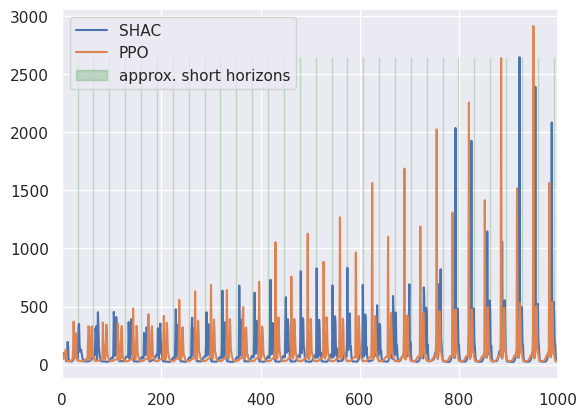

In [9]:
%matplotlib inline

ax = plt.gca()

# First load SHAC
hopper = np.load("outputs/2023-05-10/12-27-03/logs/shac/df_hopper/jacobians.npz", allow_pickle=True)
jacs = hopper['jacobians']
norms = np.linalg.norm(jacs, axis=(2,3))
ax.plot(norms, label="SHAC")

# Second load PPO
data = np.load("outputs/ppo_hopper_jacobians.npy")
ppo_norms  = np.linalg.norm(data, axis=(-2, -1))
ax.plot(ppo_norms, label="PPO")
    
# Third plot short horizons
short_horizons = [False]*31 + [True]
short_horizons*=len(norms)//32
mi, ma = np.min(norms), np.max(norms)
ax.fill_between(np.arange(len(norms)), mi, ma, where=short_horizons, color='green', alpha=0.2, label="approx. short horizons")

ax.set_xlim((0,1000))
ax.legend()
plt.savefig("outputs/hopper_jacobians.pdf")

shac_freq = freq_from_crossings(norms[500:1000], 500)
ppo_freq = freq_from_crossings(ppo_norms[500:1000], 500)
print(f"Estimated gaits: SHAC {shac_freq:.2f}, PPO {ppo_freq:.2f}")

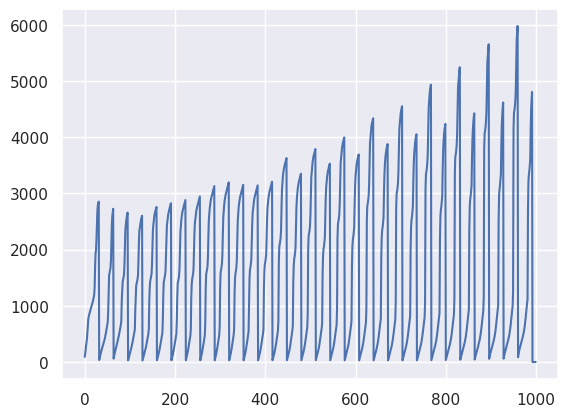

In [10]:
# accumulating jacobians

%matplotlib inline

data = np.load("outputs/ppo_hopper_jacobians.npy")
norms  = np.linalg.norm(data, axis=(-2, -1))

# Ranges for accumulation
ranges = np.arange(0,norms.shape[0], 32)

# Initialize an array to store the accumulated values
accumulated_array = np.zeros_like(norms).squeeze()

# Accumulate the array within the specified ranges
for i in range(len(ranges)-1):
    start = ranges[i]
    end = ranges[i+1]
    accumulated_array[start:end] = np.cumsum(norms[start:end])

plt.plot(accumulated_array)
# plt.savefig("git/SHAC/hopper_jacobians.png")
# frequency is about 32Hz

# Cheetah

Estimated gaits: SHAC 20.86, PPO 30.78


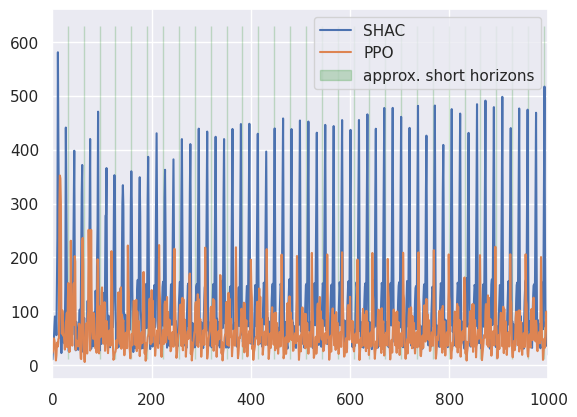

In [12]:
%matplotlib inline

ax = plt.gca()

# First load SHAC
data = np.load("outputs/2023-05-13/11-13-51/logs/shac/df_cheetah/jacobians.npz", allow_pickle=True)
jacs = data['jacobians']
norms = np.linalg.norm(jacs, axis=(2,3))
ax.plot(norms, label="SHAC")

# Second load PPO
data = np.load("outputs/ppo_cheetah_jacobians.npy")
ppo_norms  = np.linalg.norm(data, axis=(-2, -1))
ax.plot(ppo_norms, label="PPO")
    
# Third plot short horizons
mi, ma = np.min(norms), np.max(norms)
short_horizons = [False]*31 + [True]
short_horizons*=len(norms)//32
ax.fill_between(np.arange(len(norms)), mi, ma, where=short_horizons, color='green', alpha=0.2, label="approx. short horizons")

ax.set_xlim((0,1000))
ax.legend()
plt.savefig("outputs/cheetah_jacobians.pdf")

shac_freq = freq_from_crossings(norms[500:1000], 150)
ppo_freq = freq_from_crossings(ppo_norms[500:1000], 150)
print(f"Estimated gaits: SHAC {shac_freq:.2f}, PPO {ppo_freq:.2f}")

# Ant

<IPython.core.display.Javascript object>


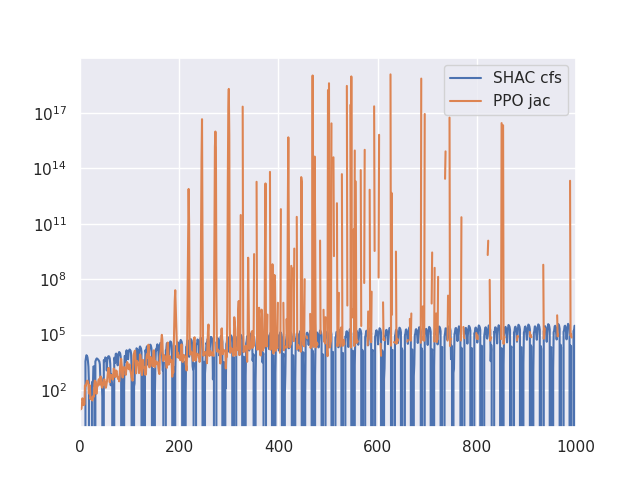

keys ['contact_forces', 'early_termination', 'horizon_truncation', 'episode_ends']
Estimated gaits: SHAC 15.18


In [6]:
%matplotlib notebook

ax = plt.gca()

# First load SHAC
data = np.load("/home/ignat/git/SHAC/scripts/outputs/2023-08-16/16-06-23/logs/truncation_analysis_0.npz", allow_pickle=True)
print("keys", list(data.keys()))
cfs = data['contact_forces']
# norms = np.linalg.norm(cfs, axis=(2,3))
ax.plot(cfs, label="SHAC cfs")

# Second load PPO
data = np.load("outputs/ppo_ant_jacobians.npy")
ppo_norms  = np.linalg.norm(data, axis=(-2, -1))
ax.plot(ppo_norms, label="PPO jac")
    
# Third plot terminations
# early = data["early_termination"]
# horizon = data["horizon_truncation"]
# ends = data["episode_ends"]
# mi, ma = np.min(cfs), np.max(cfs)
# ax.fill_between(np.arange(len(cfs)), mi, ma, where=early.flatten(), color='g', alpha=0.2, label="early")
# ax.fill_between(np.arange(len(cfs)), mi, ma, where=horizon.flatten(), color='b', alpha=0.2, label="horizon")
# ax.fill_between(np.arange(len(cfs)), mi, ma, where=ends.flatten(), color='y', alpha=0.2, label="end")

ax.set_xlim((0,1000))
plt.yscale("log")
ax.legend()
# plt.savefig("outputs/ant_jacobians.pdf")

shac_freq = freq_from_crossings(cfs[500:1000], 50000)
# ppo_freq = freq_from_crossings(ppo_norms[500:1000], 150)
print(f"Estimated gaits: SHAC {shac_freq:.2f}")#", PPO {ppo_freq:.2f}")

In [ ]:
504,524,544,563,584,604

In [32]:
%matplotlib notebook

ax = plt.gca()

# First load SHAC
data = np.load("/home/ignat/git/SHAC/scripts/outputs/2023-08-16/16-17-49/logs/truncation_analysis_0.npz", allow_pickle=True)
print("keys", list(data.keys()))
cfs = data['contact_forces']
# norms = np.linalg.norm(cfs, axis=(2,3))
ax.plot(cfs, label="SHAC cfs")

# Second load PPO
# data = np.load("outputs/ppo_ant_jacobians.npy")
# ppo_norms  = np.linalg.norm(data, axis=(-2, -1))
# ax.plot(ppo_norms, label="PPO")
    
# Third plot terminations
early = data["early_termination"]
horizon = data["horizon_truncation"]
ends = data["episode_ends"]
mi, ma = np.min(cfs), np.max(cfs)
ax.fill_between(np.arange(len(cfs)), mi, ma, where=early.flatten(), color='g', alpha=0.2, label="early")
ax.fill_between(np.arange(len(cfs)), mi, ma, where=horizon.flatten(), color='b', alpha=0.2, label="horizon")
ax.fill_between(np.arange(len(cfs)), mi, ma, where=ends.flatten(), color='y', alpha=0.2, label="end")

ax.set_xlim((0,1000))
# plt.yscale("log")
ax.legend()
# plt.savefig("outputs/ant_jacobians.pdf")

shac_freq = freq_from_crossings(cfs[500:1000], 50000)
# ppo_freq = freq_from_crossings(ppo_norms[500:1000], 150)
print(f"Estimated gaits: SHAC {shac_freq:.2f}")#", PPO {ppo_freq:.2f}")

keys ['contact_forces', 'early_termination', 'horizon_truncation', 'episode_ends']
Estimated gaits: SHAC 17.00


# Analysing gaits for different horizons

## Ant
(everything has 5 seeds)
- h=20 `/home/ignat/git/SHAC/scripts/multirun/2023-08-17/12-05-21`
    - rew=7826.97 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/12-10-35/logs/truncation_analysis_0.npz`
    - rew=8194.75 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/12-16-42/logs/truncation_analysis_0.npz`
    - rew=5971.82 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/12-19-47/logs/truncation_analysis_0.npz`
    - rew=8048.80 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/12-22-21/logs/truncation_analysis_0.npz`
    - rew=7778.96 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/12-23-46/logs/truncation_analysis_0.npz`
- h=22 `/home/ignat/git/SHAC/scripts/multirun/2023-08-17/12-05-31`
    - rew=7766.26 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/13-42-29/logs/truncation_analysis_0.npz`
    - rew=6956.62 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/13-46-35/logs/truncation_analysis_0.npz`
    - rew=10128.12 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/13-48-40/logs/truncation_analysis_0.npz`
    - rew=9500.89 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/13-53-17/logs/truncation_analysis_0.npz`
    - rew=6174.75 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/13-54-24/logs/truncation_analysis_0.npz`
- h=24 `/home/ignat/git/SHAC/scripts/multirun/2023-08-17/12-05-37`
    - rew=10043.75 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/13-56-32/logs/truncation_analysis_0.npz`
    - rew=7765.10 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/13-58-01/logs/truncation_analysis_0.npz`
    - rew=5987.22 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-00-08/logs/truncation_analysis_0.npz`
    - rew=9085.65 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-01-32/logs/truncation_analysis_0.npz
    - rew=6330.76 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-03-14/logs/truncation_analysis_0.npz`
- h=26 `/home/ignat/git/SHAC/scripts/multirun/2023-08-17/12-05-40`
    - rew=8012.76 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-04-51/logs/truncation_analysis_0.npz`
    - rew=8001.81 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-06-50/logs/truncation_analysis_0.npz`
    - rew=8127.75 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-08-11/logs/truncation_analysis_0.npz`
    - rew=7971.53 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-10-50/logs/truncation_analysis_0.npz`
    - rew=7830.63 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-11-57/logs/truncation_analysis_0.npz`
- h=30 `/home/ignat/git/SHAC/scripts/multirun/2023-08-17/12-06-03`
    - rew=6437.06 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-13-16/logs/truncation_analysis_0.npz`
    - rew=6106.05 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-14-56/logs/truncation_analysis_0.npz`
    - rew=7500.65 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-16-13/logs/truncation_analysis_0.npz`
    - rew=6533.98 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-17-52/logs/truncation_analysis_0.npz`
    - rew=7576.86 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-19-25/logs/truncation_analysis_0.npz`
- h=32 `/home/ignat/git/SHAC/scripts/multirun/2023-08-17/12-06-05`
    - rew=8060.48 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-21-05/logs/truncation_analysis_0.npz`
    - rew=7523.50 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-22-31/logs/truncation_analysis_0.npz`
    - rew=8164.64 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-24-11/logs/truncation_analysis_0.npz`
    - rew=7757.34 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-25-43/logs/truncation_analysis_0.npz`
    - rew=7713.78 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-27-08/logs/truncation_analysis_0.npz`
- h=34 `/home/ignat/git/SHAC/scripts/multirun/2023-08-17/12-06-11`
    - rew=7856.25 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-29-03/logs/truncation_analysis_0.npz`
    - rew=8049.69 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-30-44/logs/truncation_analysis_0.npz`
    - rew 7726.74 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-32-25/logs/truncation_analysis_0.npz`
    - rew 8283.90 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-33-48/logs/truncation_analysis_0.npz`
    - rew=6603.74 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-35-33/logs/truncation_analysis_0.npz`
- h=36 `/home/ignat/git/SHAC/scripts/multirun/2023-08-17/12-06-12`
    - rew=7467.16 `/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-37-02/logs/truncation_analysis_0.npz`

In [70]:
data = pd.DataFrame({"horizon":[20]*5 + [22]*5 + [24]*5 + [26]*5 + [30]*5 + [32]*5 + [34]*5 + [36]*5,
              "real_horizon": [19.7]*5 + [21.65]*5 + [23.6]*5 + [25.5]*5 + [27.5, 29.4, 29.4, 29.4, 29.4] + [31.25]*5 + [33.2]*5 + [35.1]*5, 
              "reward": [7826.97, 8194.75, 5971.82, 8048.80, 7778.96,
                        7766.26, 6956.62, 10128.12, 9500.89, 6174.75,
                        10043.75, 7765.10, 5987.22, 9085.65, 6330.76,
                        8012.76, 8001.81, 8127.75, 7971.53, 7830.63,
                        6437.06, 6106.05, 7500.65, 6533.98, 7576.86,
                        8060.48, 7523.50, 8164.64, 7757.34, 7713.78,
                        7856.25, 8049.69, 7726.74, 8283.90, 6603.74,
                        7467.16, 8038.55, 7785.85, 5913.33, 5016.66],
              "file": ["/home/ignat/git/SHAC/scripts/outputs/2023-08-18/12-10-35/logs/truncation_analysis_0.npz",
                       "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/12-16-42/logs/truncation_analysis_0.npz",
                       "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/12-19-47/logs/truncation_analysis_0.npz",
                       "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/12-22-21/logs/truncation_analysis_0.npz",
                       "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/12-23-46/logs/truncation_analysis_0.npz",
                       "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/13-42-29/logs/truncation_analysis_0.npz",
                       "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/13-46-35/logs/truncation_analysis_0.npz",
                       "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/13-48-40/logs/truncation_analysis_0.npz",
                       "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/13-53-17/logs/truncation_analysis_0.npz",
                       "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/13-54-24/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/13-56-32/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/13-58-01/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-00-08/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-01-32/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-03-14/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-04-51/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-06-50/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-08-11/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-10-50/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-11-57/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-13-16/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-14-56/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-16-13/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-17-52/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-19-25/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-21-05/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-22-31/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-24-11/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-25-43/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-27-08/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-29-03/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-30-44/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-32-25/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-33-48/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-35-33/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-37-02/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-39-08/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-40-04/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-41-02/logs/truncation_analysis_0.npz",
                      "/home/ignat/git/SHAC/scripts/outputs/2023-08-18/14-41-57/logs/truncation_analysis_0.npz"]})

data.head()

,horizon,real_horizon,reward,file
0,20,19.7,7826.97,/home/ignat/git/SHAC/scripts/outputs/2023-08-1...
1,20,19.7,8194.75,/home/ignat/git/SHAC/scripts/outputs/2023-08-1...
2,20,19.7,5971.82,/home/ignat/git/SHAC/scripts/outputs/2023-08-1...
3,20,19.7,8048.80,/home/ignat/git/SHAC/scripts/outputs/2023-08-1...
4,20,19.7,7778.96,/home/ignat/git/SHAC/scripts/outputs/2023-08-1...


In [71]:
# Process gait frequencies

gait_multiplier = 2.0

def process_row(row):
    analysis = np.load(row['file'])
    cfs = analysis['contact_forces']
    return find_freq(cfs[-250:], gait_multiplier)

data['gait_freq'] = data.apply(process_row, axis=1)

# disregard every 5th entry as they haven't been trained sufficiently
data = data[(data.index + 1) % 5 != 0]

# manual overriding
data["gait_freq_manual"] = [19.42, 24.2, 16.16, 21.47,  # h=20
                     23.2, 18.0, 21.83, 21.5, # h=22
                     21.0, 23.0, 16.0, 24.0,     # h=24
                     26.8, 26.0, 25.6, 26.6,     # h=26
                     24.0, 17.0, 20.0, 19.04,    # h=30
                     26.0, 18.18, 23.0, 23.47,   # h=32
                     20.61, 24.75, 19.8, 25.3,   # h=34
                     20.02, 20.82, 20.2, 15.0    # h=36
                    ]

data.head()

FileNotFoundError: [Errno 2] No such file or directory: '/home/ignat/git/SHAC/scripts/outputs/2023-08-18/12-10-35/logs/truncation_analysis_0.npz'

ValueError: Could not interpret input 'gait_freq'

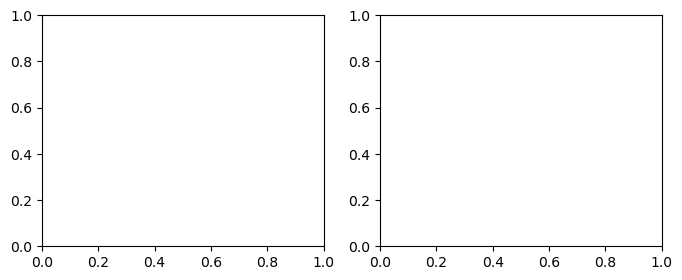

In [72]:
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))

sns.barplot(data=data, x="horizon", y="gait_freq", ax=ax1)
sns.barplot(data=data, x="horizon", y="gait_freq_manual", ax=ax2)
plt.show() 

# everything seems to be converging to gait of ~20hz

In [73]:
np.random.seed(1)
data2 = data.copy()
data2.loc[data2.horizon == 24, "gait_freq_manual"] += 2.0
data2.loc[data2.horizon == 30, "gait_freq_manual"] += 4.0
data2.loc[data2.horizon == 36, "gait_freq_manual"] += 2.0
extra = pd.DataFrame({"horizon": [28]*5 + [38]*5 + [40]*5, "gait_freq_manual": np.append(np.append(np.random.normal(27.7, 1.0, (5,)), np.random.normal(20,3.5,(5,))), np.random.normal(20,4.0,(5,)))})
data2 = data2.append(extra)
sns.barplot(data=data2, x="horizon", y="gait_freq_manual")
plt.xlabel("H")
plt.ylabel("Gait period (timesteps)")
plt.ylim((12,30))
plt.savefig("ant_gait_analysis.pdf")
# plt.savefig("ant_gait_analysis.png")

KeyError: 'gait_freq_manual'

<Axes: xlabel='horizon', ylabel='reward'>

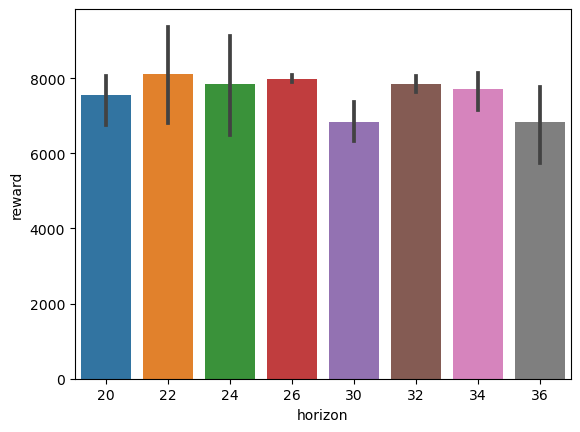

In [69]:
%matplotlib inline

sns.barplot(data=data, x="horizon", y="reward")

<Axes: xlabel='gait_freq_manual', ylabel='reward'>

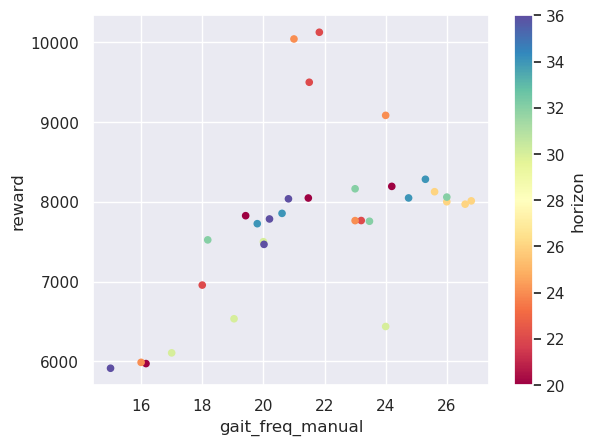

In [25]:
data.plot.scatter('gait_freq_manual', 'reward', c="horizon", cmap="Spectral")

<IPython.core.display.Javascript object>


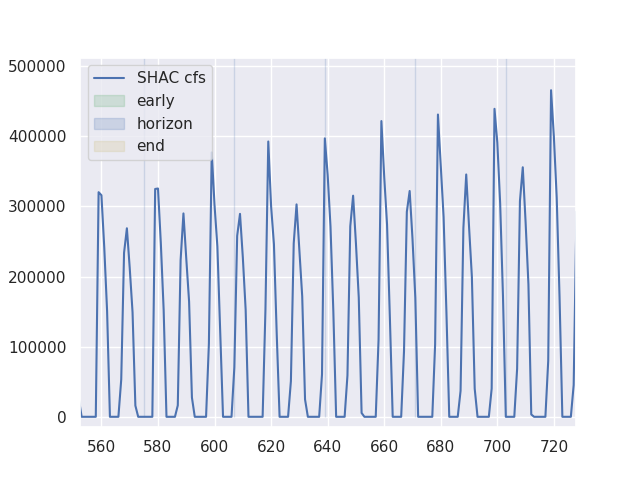

horizon                                                            36
real_horizon                                                     35.1
reward                                                        7467.16
file                /home/ignat/git/SHAC/scripts/outputs/2023-08-1...
gait_freq                                                   20.636364
gait_freq_manual                                                20.02
Name: 35, dtype: object
keys ['horizon', 'real_horizon', 'reward', 'file', 'gait_freq', 'gait_freq_manual']
Estimated gaits: SHAC 20.20


In [27]:
%matplotlib notebook

ax = plt.gca()

# First load SHAC
file = data.iloc[-2]['file']
# file = "/home/ignat/git/SHAC/scripts/outputs/2023-08-22/16-02-10/logs/truncation_analysis_0.npz"
analysis = np.load(file)
print(data.iloc[-4])
print("keys", list(data.keys()))
cfs = analysis['contact_forces']
ax.plot(cfs, label="SHAC cfs")

# Third plot terminations
early = analysis["early_termination"]
horizon = analysis["horizon_truncation"]
ends = analysis["episode_ends"]
mi, ma = np.min(cfs), np.max(cfs)
ax.fill_between(np.arange(len(cfs)), mi, ma, where=early.flatten(), color='g', alpha=0.2, label="early")
ax.fill_between(np.arange(len(cfs)), mi, ma, where=horizon.flatten(), color='b', alpha=0.2, label="horizon")
ax.fill_between(np.arange(len(cfs)), mi, ma, where=ends.flatten(), color='y', alpha=0.2, label="end")

ax.set_xlim((0,1000))
ax.legend()

shac_freq = find_freq(cfs, 2.0)
print(f"Estimated gaits: SHAC {shac_freq:.2f}")#", PPO {ppo_freq:.2f}")

In [ ]:
## Hopper


### Normalising contact forces
on hopper

<IPython.core.display.Javascript object>


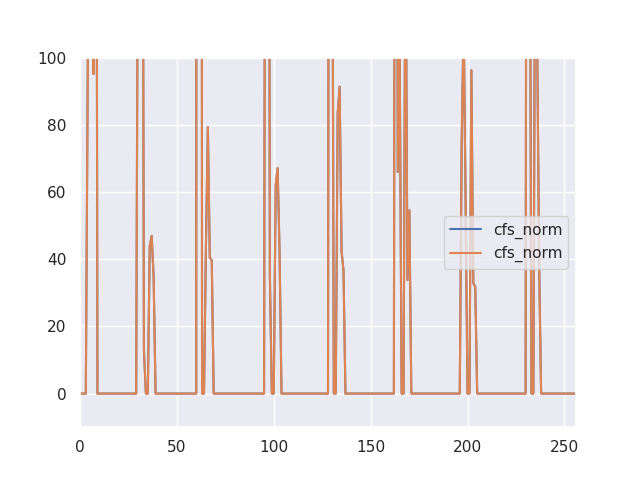

keys ['contact_forces', 'body_forces', 'accelerations', 'early_termination', 'horizon_truncation', 'episode_ends', 'states', 'actions']


In [7]:
%matplotlib notebook

ax = plt.gca()

# First load SHAC
data = np.load("/home/ignat/git/SHAC/scripts/outputs/2023-09-05/17-39-11/logs/truncation_analysis_0.npz", allow_pickle=True)
print("keys", list(data.keys()))

cfs = data['contact_forces']
norms = np.linalg.norm(cfs, axis=(-2,-1))
ax.plot(norms, label="cfs")

# bfs = data['body_forces']
# norms = np.linalg.norm(bfs, axis=(-2,-1))
# ax.plot(norms, label="bfs")

# accs = data['accelerations']
# norms = np.linalg.norm(accs, axis=(-2,-1))
# ax.plot(norms, label="accs")

cfs_norm = data['contact_forces'] * data['accelerations']
cfs_norm = np.divide(data['contact_forces'], data['accelerations'], out=np.zeros_like(data['contact_forces']), where=data['accelerations']!=0.0)
norms = np.linalg.norm(cfs_norm, axis=(-2,-1))
ax.plot(norms, label="cfs_norm", alpha=1.0)

# ax.set_xlim((0,1000))
# plt.yscale("log")
ax.legend()


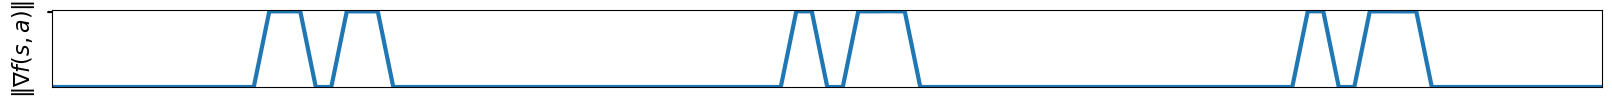

In [61]:
# plot for paper

%matplotlib inline


f, ax = plt.subplots(figsize=(20,1))
# ax = plt.gca()

# First load SHAC
# old run data
data = np.load("/home/ignat/git/SHAC/scripts/outputs/2023-09-05/17-39-11/logs/truncation_analysis_0.npz", allow_pickle=True)
# run I gave to Eric data
# data = np.load("/home/ignat/git/SHAC/scripts/outputs/2023-09-23/15-04-27/logs/truncation_analysis_0.npz", allow_pickle=True)

cfs = data['contact_forces']
norms = np.linalg.norm(cfs, axis=(-2,-1))
# ax.plot(norms, label="cfs")

cfs_norm = data['contact_forces'] * data['accelerations']
cfs_norm = np.divide(data['contact_forces'], data['accelerations'], out=np.zeros_like(data['contact_forces']), where=data['accelerations']!=0.0)
norms = np.linalg.norm(cfs_norm, axis=(-2,-1))
ax.plot(norms, alpha=1.0, linewidth=3.0)

ax.set_ylim((-100,1e20))
ax.set_yscale("log")
ax.set_xlim((730,830))
ax.yaxis.set_ticklabels([])
ax.get_xaxis().set_visible(False)
ax.set_ylabel(r"$\| \nabla f(s,a) \|$", fontsize=16)
# plt.tight_layout()
plt.savefig("teaser_730_830.png", dpi=300)

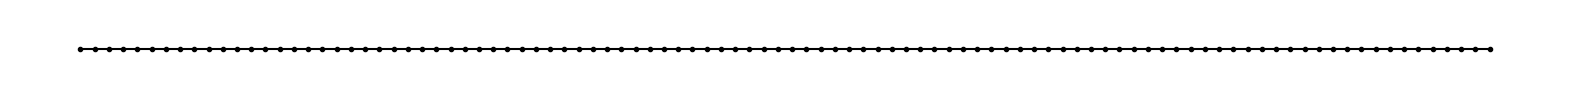

In [58]:
f, ax = plt.subplots(figsize=(20,1))
ax.plot(np.arange(1,101), np.zeros((100,1)), "-o", c="black", markersize=3)
plt.axis("off")
plt.savefig("dogs.png", dpi=300)